## Introduction to Tabular Q-Learning and Deep Q-Network

Enrique Favila Martinez, 2025

**Tabular Q-learning** is one of the simplest and most classic algorithms in reinforcement learning.  
It is a method for teaching an agent to solve sequential decision-making problems when:
- The environment has a finite and discrete set of possible states, and
- The number of actions is also discrete and small.

In tabular Q-learning, the agent keeps a **Q-table**. This table stores an estimate of the “quality” (expected long-term reward) for taking each action from each state. The table’s entries are updated over time as the agent explores the environment and sees which actions lead to better rewards.

---

### How does it work?

At each time step:
1. The agent observes its current **state**.
2. It chooses an **action** (usually using an ε-greedy policy to balance exploration and exploitation).
3. The environment returns a **reward** and a new **state**.
4. The agent updates its Q-table using the Q-learning rule:

   \[
   Q(s, a) \leftarrow Q(s, a) + \alpha \Big[r + \gamma \max_{a'} Q(s', a') - Q(s, a)\Big]
   \]

   Where:
   - \( s \) = current state
   - \( a \) = action taken
   - \( r \) = reward received
   - \( s' \) = next state
   - \( \alpha \) = learning rate
   - \( \gamma \) = discount factor for future rewards

---

### Why is it called “tabular”?

Because **all** state–action pairs are stored in a lookup **table** (not approximated with neural networks).  
Tabular Q-learning is only practical when the number of unique states and actions is small enough to fit in memory.

---

### In this project

- We use tabular Q-learning to train an agent for environments with discretized states, such as **Lunar Lander**.
- The agent learns directly by filling in the Q-table based on its experience.
- Once trained, the agent can be visualized navigating the environment by always choosing the highest-value action from its Q-table.

---

### What is DQN and how does it learn?

**DQN (Deep Q-Network)** is a reinforcement learning algorithm that combines Q-learning with a neural network.  
Instead of using a table, DQN uses the neural network to estimate the value of every possible action in any given state—even if it’s never seen that exact state before.

The agent collects experiences as it interacts with the environment and stores them in a replay buffer. During training, it samples batches of these experiences to update the network’s predictions, using the Bellman equation. Over time, the DQN network learns which actions lead to better rewards and improves its policy for solving the task.
### Train the agent with DQN

- After showcasing the performance of Tabular Q-learning in continuos state spaces, we'll switch to use DQN to train the same agent and compare the results.

---



## Lunar Lander
Lunar Lander is a Reinforcement Learning problem that allows us to train an agent interacting with an environment, to fulfill a goal.

- The goal is to teach an agent to control a spacecraft in a low gravity environment and land it in a designated area, controlling 3 thrusters.

### Lunar Lander state description
State space: Continuous — 8 floating-point numbers per state:
1.	x position
2.	y position
3.	x velocity
4.	y velocity
5.	angle
6.	angular velocity
7.	left leg contact (0/1)
8.	right leg contact (0/1)

Each state: a vector of 8 floats (**nearly infinite combinations**), which is not adequate for the nature of Tabular Q-learning. That's why we will to discretize this state space, reducing the size.

## Basic imports
Initializing environment.

In [1]:
!pip install --quiet swig
!pip install --quiet "gymnasium[box2d]"
import numpy as np
import gymnasium as gym
from collections import defaultdict
import matplotlib.pyplot as plt


# Set up the environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")
n_actions = env.action_space.n # 4 actions -> main thruster, left thruster, right thruster, do nothing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Discretization
Needed for making Tabular Q-learning possible with an environment providing a vector of continuous values instead of finite states.

> *Discretize = convert float values into integers on a range.*

The discretization works as follows:

*   For each element of the first 6 states, the value will fall into one of 6 possible values (called bins)
*   Last two elements which are binary, will only have 2 bins to fall into.
*   The range will vary between each bin, depending on the range of continuos values.

For example, for a value that can go from -3 to +3 and we define the number of bins as 6, the bins will be structured like this:

1.   bin1 - Values from -3 to -2
2.   bin2 - Values from -2 to -1
3.   bin3 - Values from -1 to 0
4.   bin4 - Values from 0 to 1
5.   bin5 - Values from 1 to 2
6.   bin6 - Values from 2 to 3

---
*  If the value is -0.7, falls into the bin 3 and returns *3* as a result.
*  In this way, we now have only 6 possible integer values for this state value.
*  While it won't reflect the real state values as precisely, it gives the model an idea of what's happening in the environment while keeping the state space simple.

In [2]:

# Discretization: choose bins for each state variable
n_bins = [6, 6, 6, 6, 6, 6, 2, 2]
bin_limits = [
    np.linspace(-1.5, 1.5, n_bins[0]-1),         # x pos
    np.linspace(-.5, 1.5, n_bins[1]-1),          # y pos
    np.linspace(-2, 2, n_bins[2]-1),             # x vel
    np.linspace(-2, 2, n_bins[3]-1),             # y vel
    np.linspace(-np.pi, np.pi, n_bins[4]-1),     # angle
    np.linspace(-2, 2, n_bins[5]-1),             # angular vel
    [0.5], [0.5]                                 # leg contacts
]

def discretize(state):
    return tuple(
        np.digitize(state[i], bin_limits[i]) for i in range(len(n_bins))
    )

# Initialize Q-table as a defaultdict
Q = defaultdict(lambda: np.zeros(n_actions))


## Hyperparameter tuning
Initialize the parameters used during training.

In [3]:
# Hyperparameters
class Config:
  alpha: float = 0.1
  gamma: float= 0.99
  epsilon: float = 1.0
  epsilon_min: float = 0.05
  epsilon_decay: float = 0.995
  n_episodes: int = 1500

cfg = Config()

## Training

Episode 100, Avg reward (last 100): -134.15, Epsilon: 0.61
Episode 200, Avg reward (last 100): -70.04, Epsilon: 0.37
Episode 300, Avg reward (last 100): -118.56, Epsilon: 0.22
Episode 400, Avg reward (last 100): -131.65, Epsilon: 0.13
Episode 500, Avg reward (last 100): -117.37, Epsilon: 0.08
Episode 600, Avg reward (last 100): -116.34, Epsilon: 0.05
Episode 700, Avg reward (last 100): -133.88, Epsilon: 0.05
Episode 800, Avg reward (last 100): -63.16, Epsilon: 0.05
Episode 900, Avg reward (last 100): -127.21, Epsilon: 0.05
Episode 1000, Avg reward (last 100): -114.80, Epsilon: 0.05
Episode 1100, Avg reward (last 100): -135.20, Epsilon: 0.05
Episode 1200, Avg reward (last 100): -110.13, Epsilon: 0.05
Episode 1300, Avg reward (last 100): -119.44, Epsilon: 0.05
Episode 1400, Avg reward (last 100): -98.03, Epsilon: 0.05
Episode 1500, Avg reward (last 100): -108.54, Epsilon: 0.05


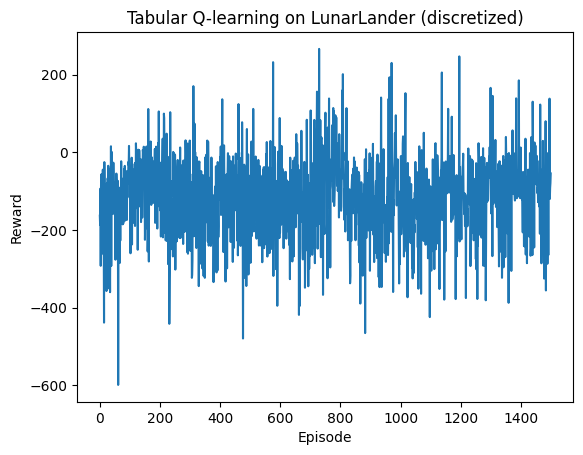

In [4]:
env.close()
env = gym.make("LunarLander-v3")

def train(cfg):
  rewards = []
  epsilon = cfg.epsilon

  for episode in range(cfg.n_episodes):
      state, _ = env.reset()
      #print("normal state",state)
      d_state = discretize(state)
      #print("discretized state",d_state)
      done = False
      total_reward = 0

      while not done:
          # ε-greedy action selection
          if np.random.rand() < epsilon:
              action = env.action_space.sample()
          else:
              action = np.argmax(Q[d_state])

          next_state, reward, terminated, truncated, info = env.step(action)
          done = terminated or truncated
          d_next_state = discretize(next_state)

          # Q-learning update
          best_next_action = np.argmax(Q[d_next_state])
          td_target = reward + cfg.gamma * Q[d_next_state][best_next_action]
          Q[d_state][action] += cfg.alpha * (td_target - Q[d_state][action])

          d_state = d_next_state
          total_reward += reward

      epsilon = max(epsilon * cfg.epsilon_decay, cfg.epsilon_min)
      rewards.append(total_reward)

      if (episode + 1) % 100 == 0:
          print(f"Episode {episode+1}, Avg reward (last 100): {np.mean(rewards[-100:]):.2f}, Epsilon: {epsilon:.2f}")

  return rewards

# Start training
cfg = Config()
rewards = train(cfg)


# Plot rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Tabular Q-learning on LunarLander (discretized)')
plt.show()

## Interpreting the results

Implementing tabular Q-learning for the LunarLander environment provided valuable insight into both the strengths and limitations of classical reinforcement learning algorithms. While tabular Q-learning is conceptually simple and works well in small, fully discrete environments (like Taxi-v3 or FrozenLake-v1), its shortcomings become clear in more complex, high-dimensional, and continuous state spaces like LunarLander.

Despite experimenting with different numbers of discretization bins and hyperparameter tuning (learning rate, discount factor, epsilon decay), the agent's performance plateaued far below the environment's “solved” threshold. The main factors limiting performance were:

- **State Space Explosion:** Even a modest number of bins for each of LunarLander's 8 state variables creates thousands to millions of possible state combinations. The agent cannot feasibly visit and learn all of them within a reasonable number of episodes.

- **Lack of Generalization:** Tabular Q-learning treats each discretized state as entirely separate, so learning in one state does not transfer to similar states. This is especially problematic in environments where similar states should lead to similar behavior.

- **Data Inefficiency:** The algorithm is fundamentally data-inefficient in large or continuous spaces, requiring vastly more episodes to see even incremental improvement compared to function-approximation methods.

- **Poor Performance Ceiling:** Hyperparameter tuning provided only marginal gains, and rewards remained inconsistent and well below what's achievable with more advanced techniques.

These limitations are not a reflection of the algorithm's correctness or implementation, but rather of its inherent design. In contrast, Deep Q-Networks (DQN) and other neural network-based methods are explicitly designed to handle large or continuous state spaces by learning representations and generalizing across states.

### **Conclusion**
We're gonna see an improvement in rewards using a a DQN approach, designed for more complex state spaces, like Lunar Lander.

## DQN impementation

## Aditional imports

In [5]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque


## Hyperparameters


In [6]:

class Config:
  # Hyperparameters
  gamma: float = 0.99
  lr: float = 1e-3
  batch_size: int = 64
  buffer_size: int = 100_000
  min_replay_size: int = 10_000
  epsilon_start: float = 1.0
  epsilon_end: float = 0.05
  epsilon_decay: float = 0.99999
  num_episodes: int = 2000


cfg = Config() # Reinitialization of cfg
obs_dim = env.observation_space.shape[0]


## DQN Model Architecture Definition


In [7]:

class DQN(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, x):
        return self.net(x)


## Reply Buffer

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(obs_dim, n_actions).to(device)
target_net = DQN(obs_dim, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=cfg.lr)
replay_buffer = deque(maxlen=cfg.buffer_size)


## Epsilon - Greedy Actions

In [9]:

def epsilon_greedy_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = policy_net(state)
        return int(q_values.argmax().item())


## Training

<ipython-input-10-1794789559>:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states).to(device)


Episode 10, Avg reward (last 10): -209.38, Epsilon: 0.99
Episode 20, Avg reward (last 10): -240.00, Epsilon: 0.98
Episode 30, Avg reward (last 10): -185.91, Epsilon: 0.97
Episode 40, Avg reward (last 10): -147.94, Epsilon: 0.96
Episode 50, Avg reward (last 10): -130.01, Epsilon: 0.95
Episode 60, Avg reward (last 10): -172.81, Epsilon: 0.94
Episode 70, Avg reward (last 10): -205.77, Epsilon: 0.93
Episode 80, Avg reward (last 10): -110.06, Epsilon: 0.92
Episode 90, Avg reward (last 10): -138.39, Epsilon: 0.92
Episode 100, Avg reward (last 10): -141.42, Epsilon: 0.91
Episode 110, Avg reward (last 10): -159.35, Epsilon: 0.90
Episode 120, Avg reward (last 10): -126.19, Epsilon: 0.89
Episode 130, Avg reward (last 10): -106.66, Epsilon: 0.88
Episode 140, Avg reward (last 10): -111.28, Epsilon: 0.87
Episode 150, Avg reward (last 10): -163.58, Epsilon: 0.86
Episode 160, Avg reward (last 10): -96.52, Epsilon: 0.85
Episode 170, Avg reward (last 10): -100.66, Epsilon: 0.84
Episode 180, Avg reward 

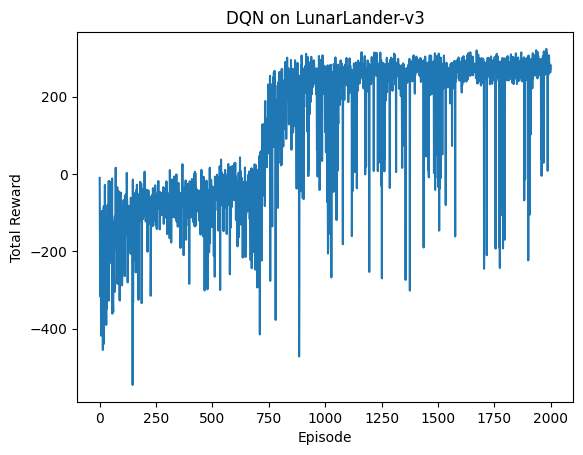

In [10]:
env.close()
env = gym.make("LunarLander-v3")

def train(cfg):
  state, _ = env.reset()

  # Training starts only after reaching min replay size
  for _ in range(cfg.min_replay_size):
      action = env.action_space.sample()
      next_state, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      replay_buffer.append((state, action, reward, next_state, done))
      if done:
          state, _ = env.reset()
      else:
          state = next_state

  target_update_freq = 1000  # every 1000 steps
  all_rewards = []
  epsilon = cfg.epsilon_start
  steps = 0

  state, _ = env.reset()

  for episode in range(cfg.num_episodes):
      state, _ = env.reset()
      episode_reward = 0
      done = False

      while not done:
          # Select action
          epsilon = max(cfg.epsilon_end, epsilon * cfg.epsilon_decay)
          action = epsilon_greedy_action(state, epsilon)

          # Step
          next_state, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          replay_buffer.append((state, action, reward, next_state, done))
          episode_reward += reward
          state = next_state

          # Sample batch and train
          batch = random.sample(replay_buffer, cfg.batch_size)
          states, actions, rewards, next_states, dones = zip(*batch)
          states = torch.FloatTensor(states).to(device)
          actions = torch.LongTensor(actions).unsqueeze(1).to(device)
          rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
          next_states = torch.FloatTensor(next_states).to(device)
          dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

          # Q(s, a)
          q_values = policy_net(states).gather(1, actions)
          # Q(s', a') from target network
          next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
          # Bellman target
          targets = rewards + cfg.gamma * next_q_values * (1 - dones)

          loss = nn.MSELoss()(q_values, targets)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Update target network
          if steps % target_update_freq == 0:
              target_net.load_state_dict(policy_net.state_dict())

          steps += 1

      all_rewards.append(episode_reward)
      if (episode + 1) % 10 == 0:
          avg_reward = np.mean(all_rewards[-10:]) # Get the average of the last 10 reward values
          print(f"Episode {episode+1}, Avg reward (last 10): {avg_reward:.2f}, Epsilon: {epsilon:.2f}")

  env.close()
  return all_rewards

cfg = Config()
all_rewards = train(cfg)


plt.plot(all_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN on LunarLander-v3')
plt.show()



## Why did DQN perform better than Tabular Q-learning in LunarLander?

DQN (Deep Q-Network) performed much better than tabular Q-learning in LunarLander because DQN uses a neural network to **generalize** across the huge, continuous state space. It can learn patterns and similarities between similar states, allowing it to handle situations it hasn’t seen before.

Tabular Q-learning, on the other hand, can only remember exact state–action pairs that it has already visited (after discretizing), and treats every new state as totally unique. In LunarLander, there are so many possible states that tabular Q-learning can’t learn efficiently, and it struggles to improve even with lots of training.

**In summary:**  
DQN is designed to handle complex, high-dimensional environments like LunarLander, while tabular Q-learning is only practical in small, simple problems.